# Exercise 2

Team members: Agata Kaczmarek (uni-id), Mateusz Stączek (uni-id)

In [ ]:
from sklearn.datasets import make_moons
from matplotlib import pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import pandas as pd

from sklearn.mixture import GaussianMixture
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

torch.manual_seed(42)

RANDOM_STATE = 42

/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Two-dimensional data with bottleneck

### Create training and test datasets.

At the beginning two datasets are created - train and test. They are 2-dimensional datasets, created with the help of the function `sklearn.datasets.make_moons()` **at noise level 0.1**. The function allows to set various sizes for both datasets. Default noise level is 0.1, hiwever it can be changed.

In [ ]:
def get_moons_data(n_train, n_test=0, noise=0.1, random_state=RANDOM_STATE):
    """
    Generate data from make_moons.
    """
    X_train, y_train = make_moons(n_samples=n_train, noise=noise, random_state=random_state)
    X_test, y_test = make_moons(n_samples=n_test, noise=noise, random_state=random_state)
    return X_train, X_test

In [ ]:
X_train, X_test = get_moons_data(1000, 900)

<div style="color: green; font-weight: bold">Comment - our solution is equivalent:

- We created the function, which creates both datasets, from the make_moons function, and did not use train_test_split. The train_test_split is a more elegant way to do the split than the one we done, but our solution is still valid - it allows to generate train and test dataset independently and of various sizes, as can be seen on plots below.

</div>

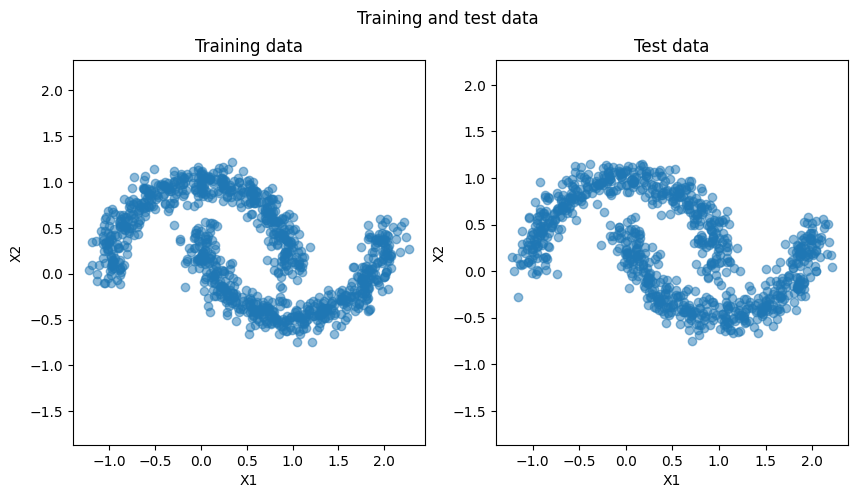

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(X_train[:, 0], X_train[:, 1], alpha=0.5)
ax[0].set_title('Training data')
ax[0].set_xlabel('X1')
ax[0].set_ylabel('X2')
ax[0].axis('equal')
ax[1].scatter(X_test[:, 0], X_test[:, 1], alpha=0.5)
ax[1].set_title('Test data')
ax[1].set_xlabel('X1')
ax[1].set_ylabel('X2')
ax[1].axis('equal')
fig.suptitle('Training and test data')
plt.show()

### Implementation of the autoencoder

Use Pytorch. 

The autoencoder's constructor should have four arguments:
- `input_size`: the data dimension (so that we can later reuse the autoencoder in task 3)
- `bottleneck_size`: the code dimension
- `hidden_size`: the dimension of the hidden layers (should be larger than the data dimension!)
- `layers`: the number of hidden layers

In the present task, we obviously have `input_size=2` and `bottleneck_size=1`, the other two arguments are hyperparameters. 

All interior layers should be linear followed by a ReLU. 

The output layers of both encoder and decoder are just linear. 

The decoder architecture should be a mirror of the encoder architecture.

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, bottleneck_size, hidden_size, layers):
        """
        Args:
            input_size (int): the data dimension
            bottleneck_size (int): the code dimension
            hidden_size (int): the dimension of the hidden layers (should be larger than the data dimension!)
            layers (int): the number of hidden layers
        """
        super(Autoencoder, self).__init__()
        self.input_size = input_size
        self.bottleneck_size = bottleneck_size
        self.hidden_size = hidden_size
        self.layers = layers
        self._build_encoder()
        self._build_decoder()
    
    def _build_encoder(self):
        """
        Build the encoder part of the autoencoder
        """
        self.encoder = nn.Sequential()
        self.encoder.add_module("linear1", nn.Linear(self.input_size, self.hidden_size))
        self.encoder.add_module("relu1", nn.ReLU())
        for i in range(self.layers-1):
            self.encoder.add_module("linear"+str(i+2), nn.Linear(self.hidden_size, self.hidden_size))
            self.encoder.add_module("relu"+str(i+2), nn.ReLU())
        self.encoder.add_module("linear"+str(self.layers+1), nn.Linear(self.hidden_size, self.bottleneck_size))
        
    def _build_decoder(self):
        """
        Build the decoder part of the autoencoder
        """
        self.decoder = nn.Sequential()
        self.decoder.add_module("linear1", nn.Linear(self.bottleneck_size, self.hidden_size))
        self.decoder.add_module("relu1", nn.ReLU())

        for i in range(self.layers-1):
            self.decoder.add_module("linear"+str(i+2), nn.Linear(self.hidden_size, self.hidden_size))
            self.decoder.add_module("relu"+str(i+2), nn.ReLU())

        self.decoder.add_module("linear"+str(self.layers+1), nn.Linear(self.hidden_size, self.input_size))

    def forward(self, x):
        """
        Args:
            x (torch.Tensor): input data
        """
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def encode(self, x):
        """
        Args:
            x (torch.Tensor): input data
        """
        return self.encoder(x)
    
    def decode(self, x):
        """
        Args:
            x (torch.Tensor): input data
        """
        return self.decoder(x)

<div style="color: green; font-weight: bold">Comment - our solution is equivalent:

- The only difference with the given solution are the names of the layers added to encoder and decoder: in sample solution the names are like: str(2*i), and in our solution "linear"+str(i+2). This does not influence the results and model, it is only difference in convention of naming.

</div>

### Implementation of the training loop

Implement a training function `train_autoencoder()` using:
- the `torch.optim.Adam optimizer` (with default learning rate lr=0.001) and 
- the mean-squared reconstruction error. 

Training has thus three hyperparameters: 
- the size of the training set, 
- the number of epochs, 
- and the learning rate (or learning rate schedule). 

In [ ]:
def train_autoencoder(model, X_train, X_test, n_epochs, batch_size, learning_rate=0.001, size_of_the_training_set=-1):
    """
    Args:
        model (nn.Module): the autoencoder model
        X_train (np.ndarray): the training data
        X_test (np.ndarray): the test data
        n_epochs (int): the number of training epochs
        batch_size (int): the batch size
        learning_rate (float): the learning rate
        size_of_the_training_set (int): subset of the training set to use (default: -1, i.e. use the whole training set)
    """
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    test_losses = []

    X_train = X_train[:size_of_the_training_set]
    
    data_train = torch.from_numpy(X_train).float()
    data_test = torch.from_numpy(X_test).float()

    # loss before training
    with torch.no_grad():
        outputs = model(data_train)
        loss = criterion(outputs, data_train)
        train_losses.append(loss.item())
        outputs = model(data_test)
        loss = criterion(outputs, data_test)
        test_losses.append(loss.item())
    print(f"Epoch 0/{n_epochs}: train_loss={train_losses[-1]:.4f}, test_loss={test_losses[-1]:.4f}")

    # trainning
    for epoch in range(n_epochs):
        train_loss = 0
        test_loss = 0
        for i in range(0, len(X_train), batch_size):
            data = data_train[i:i+batch_size]
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, data)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * len(data)
        train_loss /= len(X_train)
        train_losses.append(train_loss)
        with torch.no_grad():
            for i in range(0, len(X_test), batch_size):
                data = data_test[i:i+batch_size]
                outputs = model(data)
                loss = criterion(outputs, data)
                test_loss += loss.item() * len(data)
            test_loss /= len(X_test)
            test_losses.append(test_loss)
        if (epoch+1) % (n_epochs//10) == 0:
            print(f"Epoch {epoch+1}/{n_epochs}: train_loss={train_loss:.4f}, test_loss={test_loss:.4f}")
    df = pd.DataFrame({'train': train_losses, 'test': test_losses, 'epoch': list(range(n_epochs+1))})
    return df


<div style="color: green; font-weight: bold">Comment - our solution is valid alternative:

- There are some differences between our code and the sample solution. In our solution we also calculate loss before training and durigng training on the test data. It does not change the results, but it allows to track the results. The minor inconvenience is that it makes the training time longer, as there are more computations required. 
- Also another difference it that in sample solution for each index to len(X_train) there is a random batch of data, which influences the performance of the model, as the model "sees" various data samples different number of times, so the training is not "equally" distributed. In our solution we train the model on consecutive samples, which are seen by the model equal number of times.
- In the sample solution output=model.forward(data), in our output=model(data). Our solution is also good one and is consistent with the tutorial about training models in pytorch documentation.

</div>

### Training a sample autoencoder

During design and debugging of your code, your should start small (e.g. 1000 training points, 10 epochs, 2 layers) to ensure rapid training. 

Gradually increase network size and training effort once your results start looking promising.

When your code works, train and evaluate autoencodes with two moons at noise level 0.1.

In [ ]:
X_train, X_test = get_moons_data(1000, 900)

model = Autoencoder(input_size=2, bottleneck_size=1, hidden_size=64, layers=2)

In [ ]:
df_losses = train_autoencoder(model = model,
                            X_train = X_train,
                            X_test = X_test,
                            n_epochs = 100,
                            batch_size = 32,
                            learning_rate = 0.001)

Epoch 0/100: train_loss=0.7946, test_loss=0.8053
Epoch 10/100: train_loss=0.0389, test_loss=0.0374
Epoch 20/100: train_loss=0.0309, test_loss=0.0304
Epoch 30/100: train_loss=0.0216, test_loss=0.0232
Epoch 40/100: train_loss=0.0135, test_loss=0.0164
Epoch 50/100: train_loss=0.0105, test_loss=0.0135
Epoch 60/100: train_loss=0.0093, test_loss=0.0125
Epoch 70/100: train_loss=0.0084, test_loss=0.0117
Epoch 80/100: train_loss=0.0079, test_loss=0.0110
Epoch 90/100: train_loss=0.0076, test_loss=0.0106
Epoch 100/100: train_loss=0.0074, test_loss=0.0104


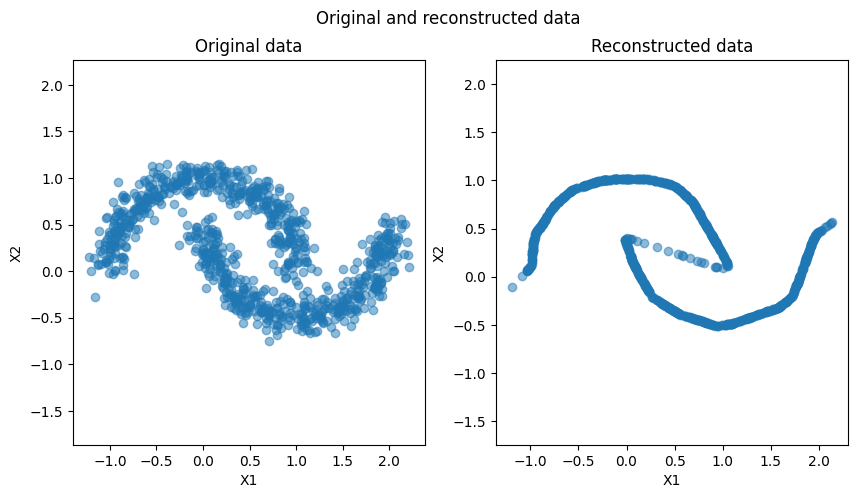

In [ ]:
with torch.no_grad():
    data = torch.from_numpy(X_test).float()
    outputs = model(data)
    outputs = outputs.numpy()
    data = data.numpy()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(data[:, 0], data[:, 1], alpha=0.5)
ax[0].set_title('Original data')
ax[0].set_xlabel('X1')
ax[0].set_ylabel('X2')
ax[0].axis('equal')
ax[1].scatter(outputs[:, 0], outputs[:, 1], alpha=0.5)
ax[1].set_title('Reconstructed data')
ax[1].set_xlabel('X1')
ax[1].set_ylabel('X2')
ax[1].axis('equal')
fig.suptitle('Original and reconstructed data')
plt.show()

Comment: Training works, can tweak parameters and train for more epochs to achieve better results. Since bottleneck is a single neuron, it is easy for decoder to create a single line, with no noise.

<div style="color: green; font-weight: bold">Comment - solutions are equivalent:

Training is conduted and works, plots are also readable, with captions on the axes and titles.

</div>

### 1.1 Evaluating hyperparameters

Investigate systematically the effect of the hyperparameters. 

Report your findings in suitable plots, e.g.:
- test set reconstruction error as a function of hyperparameters, 
- and reconstructed vs. original points for selected settings. 

Make sure that all plots are properly labeled (title, axis labels, legend). Comment on your findings.

In [ ]:
from functools import partial

default_model_parameters = {
    'input_size': 2,
    'bottleneck_size': 1,
    'hidden_size': 64,
    'layers': 2
}

default_training_parameters = {
    'n_epochs': 100,
    'batch_size': 32,
    'learning_rate': 0.001,
    'size_of_the_training_set': -1
}

DefaultAutoencoder = partial(Autoencoder, **default_model_parameters)

In [ ]:
def compute_losses_diff_training(model_to_initialize, hyperparameter_name, hyperparameter_values, X_train, X_test, other_training_parameters):
    """
    Computes losses for different values of given training hyperparameter.

    Args:
        model_to_initialize (nn.Module): the model to initialize
        hyperparameter_name (str): the name of the hyperparameter to vary
        hyperparameter_values (list): the values of the hyperparameter to try
        X_train (np.ndarray): the training data
        X_test (np.ndarray): the test data
        other_training_parameters (dict): the training parameters
    """
    df_results = pd.DataFrame()
    trained_models = {}
    used_training_parameters = {**other_training_parameters}
    used_training_parameters[hyperparameter_name] = None # this one will vary
    for hyperparameter_value in hyperparameter_values:
        used_training_parameters[hyperparameter_name] = hyperparameter_value
        model = model_to_initialize()
        df_losses = train_autoencoder(model = model,
                                                X_train = X_train,
                                                X_test = X_test,
                                                **used_training_parameters)
        df_losses['hyperparameter_value'] = hyperparameter_value
        df_results = pd.concat([df_results, df_losses])
        trained_models[hyperparameter_value] = model
    df_results['hyperparameter_name'] = hyperparameter_name
    return df_results, trained_models

def compute_losses_diff_model(model_class, hyperparameter_name, hyperparameter_values, X_train, X_test, other_model_parameters):
    """
    Computes losses for different values of given model hyperparameter.
    Args:
        model_class (nn.Module): the model class
        hyperparameter_name (str): the name of the hyperparameter to vary
        hyperparameter_values (list): the values of the hyperparameter to try
        X_train (np.ndarray): the training data
        X_test (np.ndarray): the test data
        other_model_parameters (dict): the model parameters
    """
    df_results = pd.DataFrame()
    trained_models = {}
    used_model_parameters = {**other_model_parameters}
    used_model_parameters[hyperparameter_name] = None # this one will vary
    for hyperparameter_value in hyperparameter_values:
        used_model_parameters[hyperparameter_name] = hyperparameter_value
        model = model_class(**used_model_parameters)
        df_losses = train_autoencoder(model = model,
                                                X_train = X_train,
                                                X_test = X_test,
                                                **default_training_parameters)
        df_losses['hyperparameter_value'] = hyperparameter_value
        df_results = pd.concat([df_results, df_losses])
        trained_models[hyperparameter_value] = model
    df_results['hyperparameter_name'] = hyperparameter_name
    return df_results, trained_models

In [ ]:
def plot_hyperparameter(df, trained_models, title, X_test):
    """
    Args:
        df (pd.DataFrame): the dataframe containing the losses
        trained_models (dict): the trained models
        title (str): the title of the plot
        X_test (np.ndarray): the test data
    """
    # plot test losses during training
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].set_title("Reconstruction loss (Test) during training")
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Test reconstruction loss')
    sns.lineplot(data=df, x='epoch', y='test', hue='hyperparameter_value', ax=ax[0])
    ax[0].legend(title='Hyperparameter value')

    ax[1].set_xlabel('X1')
    ax[1].set_ylabel('X2')
    ax[1].axis('equal')

    # get the best model
    row_with_best_model = df[df['test'] == df['test'].min()]
    best_model_param_value = row_with_best_model['hyperparameter_value'].values[0]
    best_model = trained_models[best_model_param_value]
    ax[1].set_title(f'Original vs reconstructed data\nbest model hyperparam = {best_model_param_value}')
    
    # compute the reconstruction and plot it
    with torch.no_grad():
        data = torch.from_numpy(X_test).float()
        outputs = best_model(data)
        outputs = outputs.numpy()
        data = data.numpy()

    ax[1].scatter(data[:, 0], data[:, 1], alpha=0.5)
    ax[1].scatter(outputs[:, 0], outputs[:, 1], alpha=0.5)
    ax[1].legend(['Original data', 'Reconstructed data'])
    fig.suptitle(title, y=1.05, fontsize=16)
    plt.show()

#### Hyperparameters to investigate in training (according to task description):
- size of the training set
- number of epochs
- learning rate

In [ ]:
parameters_to_evaluate = {
    'n_epochs': [10, 50, 100],
    'learning_rate': [0.0001, 0.001, 0.01],
    'size_of_the_training_set': [10, 100, 1000]
}

In [ ]:
df_n_epochs, trained_models_n_epochs = compute_losses_diff_training(model_to_initialize=DefaultAutoencoder,
                                                            hyperparameter_name='n_epochs',
                                                            hyperparameter_values=parameters_to_evaluate['n_epochs'],
                                                            X_train=X_train,
                                                            X_test=X_test,
                                                            other_training_parameters=default_training_parameters)

df_learning_rate, trained_models_learning_rate = compute_losses_diff_training(model_to_initialize=DefaultAutoencoder,
                                                            hyperparameter_name='learning_rate',
                                                            hyperparameter_values=parameters_to_evaluate['learning_rate'],
                                                            X_train=X_train,
                                                            X_test=X_test,
                                                            other_training_parameters=default_training_parameters)

df_size_of_the_training_set, trained_models_size_of_the_training_set = compute_losses_diff_training(model_to_initialize=DefaultAutoencoder,
                                                            hyperparameter_name='size_of_the_training_set',
                                                            hyperparameter_values=parameters_to_evaluate['size_of_the_training_set'],
                                                            X_train=X_train,
                                                            X_test=X_test,
                                                            other_training_parameters=default_training_parameters)

Epoch 0/10: train_loss=0.6103, test_loss=0.6173
Epoch 1/10: train_loss=0.4665, test_loss=0.2591
Epoch 2/10: train_loss=0.1277, test_loss=0.0914
Epoch 3/10: train_loss=0.0820, test_loss=0.0751
Epoch 4/10: train_loss=0.0683, test_loss=0.0620
Epoch 5/10: train_loss=0.0561, test_loss=0.0500
Epoch 6/10: train_loss=0.0478, test_loss=0.0437
Epoch 7/10: train_loss=0.0434, test_loss=0.0403
Epoch 8/10: train_loss=0.0411, test_loss=0.0387
Epoch 9/10: train_loss=0.0397, test_loss=0.0376
Epoch 10/10: train_loss=0.0386, test_loss=0.0366
Epoch 0/50: train_loss=0.6732, test_loss=0.6812
Epoch 5/50: train_loss=0.0561, test_loss=0.0514
Epoch 10/50: train_loss=0.0383, test_loss=0.0365
Epoch 15/50: train_loss=0.0336, test_loss=0.0325
Epoch 20/50: train_loss=0.0296, test_loss=0.0286
Epoch 25/50: train_loss=0.0240, test_loss=0.0237
Epoch 30/50: train_loss=0.0174, test_loss=0.0194
Epoch 35/50: train_loss=0.0136, test_loss=0.0170
Epoch 40/50: train_loss=0.0116, test_loss=0.0157
Epoch 45/50: train_loss=0.0104, 

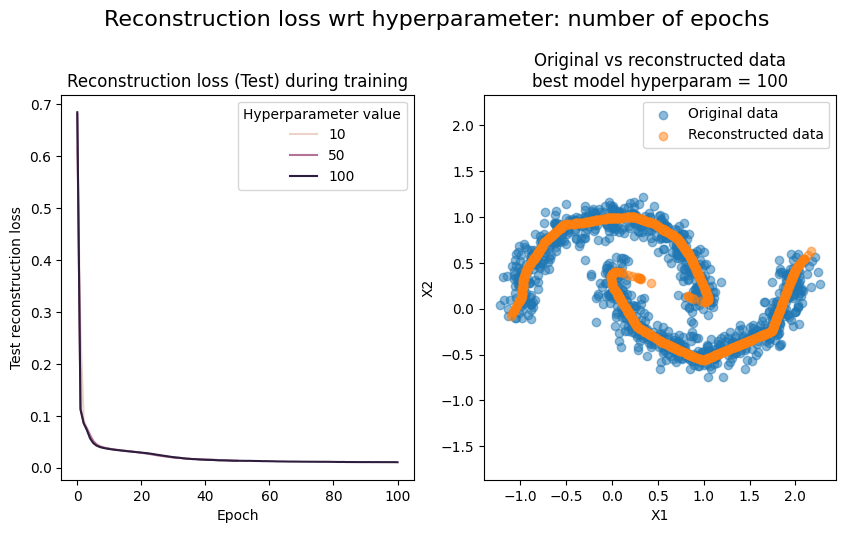

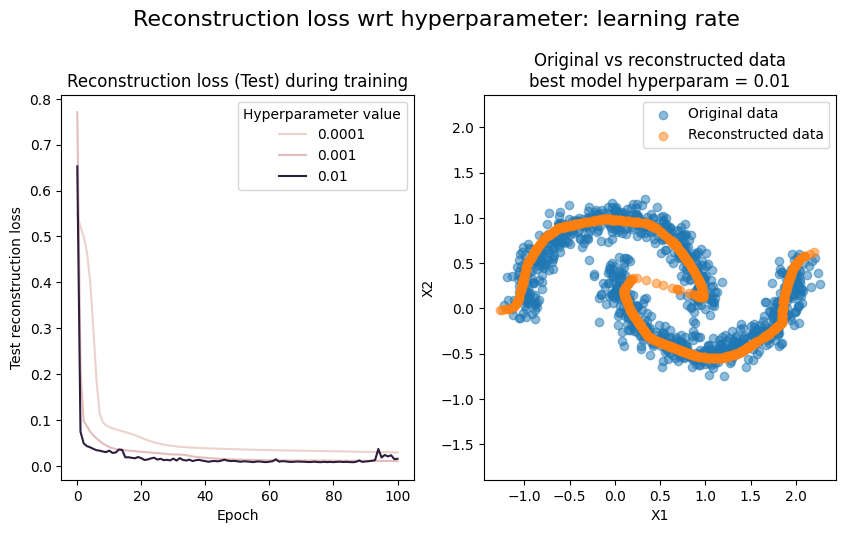

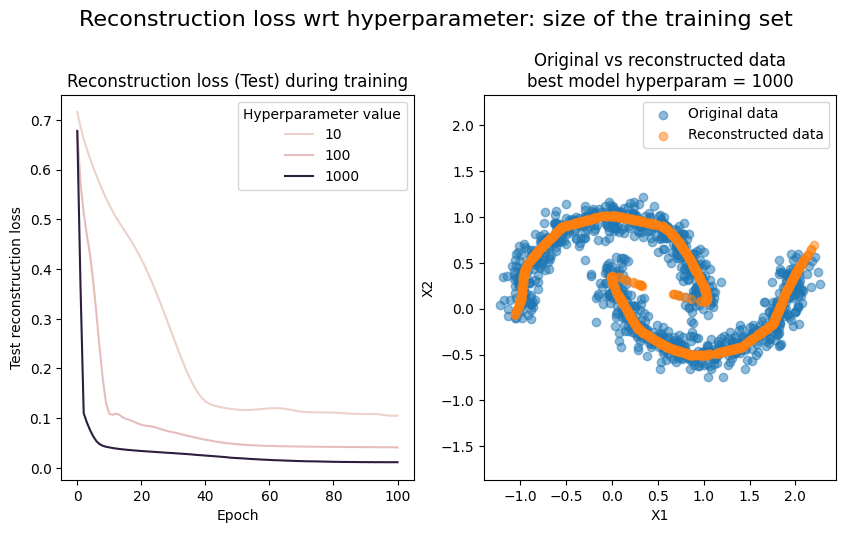

In [ ]:
plot_hyperparameter(df=df_n_epochs, trained_models=trained_models_n_epochs, title='Reconstruction loss wrt hyperparameter: number of epochs', X_test=X_train)
plot_hyperparameter(df=df_learning_rate, trained_models=trained_models_learning_rate, title='Reconstruction loss wrt hyperparameter: learning rate', X_test=X_train)
plot_hyperparameter(df=df_size_of_the_training_set, trained_models=trained_models_size_of_the_training_set, title='Reconstruction loss wrt hyperparameter: size of the training set', X_test=X_train)

#### Hyperparameters to investigate in model architecture (according to task description):
- hidden size
- layers

In [ ]:
default_model_parameters = {
    'input_size': 2,
    'bottleneck_size': 1,
    'hidden_size': 32,
    'layers': 2
}

parameters_to_evaluate = {
    'hidden_size': [2, 8, 32, 128],
    'layers': [1, 2, 4, 6]
}

DefaultAutoencoder_32 = partial(Autoencoder, **default_model_parameters)

In [ ]:
df_hidden_size, trained_models_hidden_size = compute_losses_diff_model(model_class=DefaultAutoencoder_32,
                                                            hyperparameter_name='hidden_size',
                                                            hyperparameter_values=parameters_to_evaluate['hidden_size'],
                                                            X_train=X_train,
                                                            X_test=X_test,
                                                            other_model_parameters=default_model_parameters)

df_layers, trained_models_layers = compute_losses_diff_model(model_class=DefaultAutoencoder_32,
                                                            hyperparameter_name='layers',
                                                            hyperparameter_values=parameters_to_evaluate['layers'],
                                                            X_train=X_train,
                                                            X_test=X_test,
                                                            other_model_parameters=default_model_parameters)

Epoch 0/100: train_loss=0.8748, test_loss=0.8864
Epoch 10/100: train_loss=0.5408, test_loss=0.5391
Epoch 20/100: train_loss=0.5074, test_loss=0.5093
Epoch 30/100: train_loss=0.5040, test_loss=0.4958
Epoch 40/100: train_loss=0.2017, test_loss=0.1960
Epoch 50/100: train_loss=0.1462, test_loss=0.1424
Epoch 60/100: train_loss=0.1221, test_loss=0.1186
Epoch 70/100: train_loss=0.1096, test_loss=0.1063
Epoch 80/100: train_loss=0.1030, test_loss=0.0998
Epoch 90/100: train_loss=0.0995, test_loss=0.0963
Epoch 100/100: train_loss=0.0977, test_loss=0.0945
Epoch 0/100: train_loss=0.6507, test_loss=0.6583
Epoch 10/100: train_loss=0.1536, test_loss=0.1378
Epoch 20/100: train_loss=0.0824, test_loss=0.0788
Epoch 30/100: train_loss=0.0678, test_loss=0.0647
Epoch 40/100: train_loss=0.0528, test_loss=0.0509
Epoch 50/100: train_loss=0.0447, test_loss=0.0435
Epoch 60/100: train_loss=0.0416, test_loss=0.0406
Epoch 70/100: train_loss=0.0399, test_loss=0.0391
Epoch 80/100: train_loss=0.0388, test_loss=0.0382
E

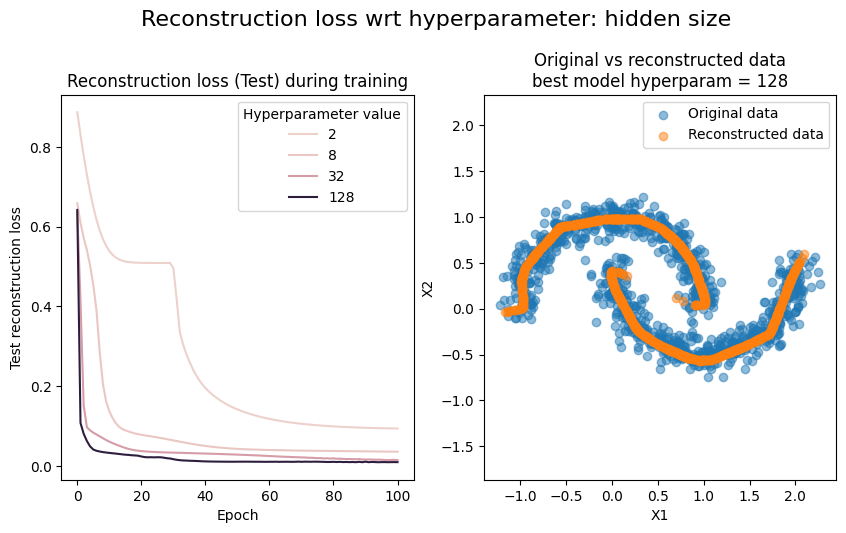

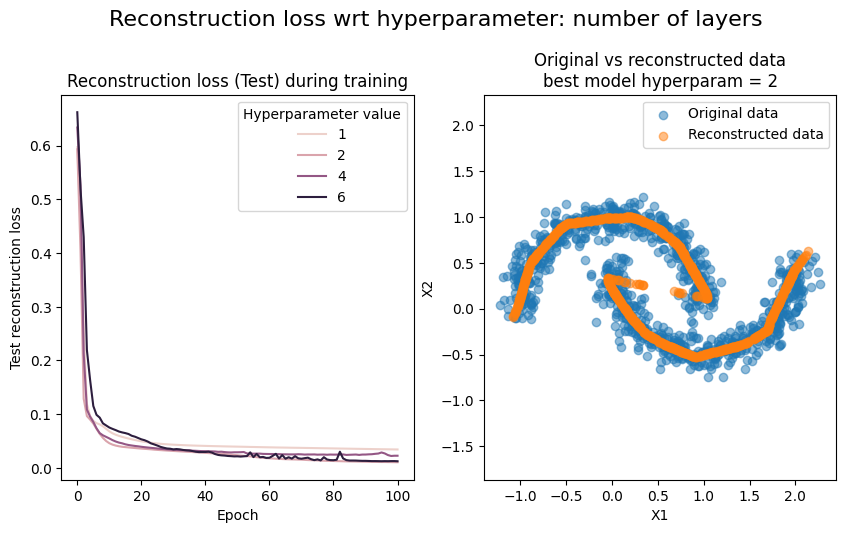

In [ ]:
plot_hyperparameter(df=df_hidden_size, trained_models=trained_models_hidden_size, title='Reconstruction loss wrt hyperparameter: hidden size', X_test=X_train)
plot_hyperparameter(df=df_layers, trained_models=trained_models_layers, title='Reconstruction loss wrt hyperparameter: number of layers', X_test=X_train)

Comments: 
- epochs - the more, the better, but differences get very small after 50 epochs
- learning rate - too small makes the model learn slower, too large and the loss is not decreasing steadily
- training set size - having the same number of epochs, the more, the better. If the number of backpropagation steps was equal, the results would probably be the same for all training set sizes presented
- hidden size - too small, and the model won't be able to learn. Larger is sufficient to obtain very good results pretty fast
- layers - if we had tested it with smaller hidden size, the results might differ, but to maintain default parameters fixed our results show that numeber of layers does not really matter. Having only 1 layers is not enough though.

<div style="color: green; font-weight: bold">Comment - valid alternative:

- As in the sample solution, we conducted experiments on various hyperparameters required in the task description. In some cases the conclusions differ, but it is the result of various setting of the different parameters. For our experiments we also provide charts, which can be used to draw conclusions about the results of the experiments. The only minor issue is, that we could have made more experiments with various settings between the hyperparameters used for the experiments.

</div>

### 1.2 Investigation of the best model

For the best hyperparameter settings you found, investigate how much the reconstruction varies when you repeat training with the same or different datasets. Comment on your observations.

#### Variables to investigate:
- size of the training set

Repeat each training a few times to compute variance and represent with boxplot.

In [ ]:
def compute_losses_diff_dataset_size(model_to_initialize, dataset_sizes, training_parameters, repetitions):
    """
    Args:
        model_to_initialize (nn.Module): the model to initialize
        dataset_sizes (list): the dataset sizes to try
        X_test (np.ndarray): the test data
        other_training_parameters (dict): the training parameters
    """
    df_results = pd.DataFrame()
    for dataset_size in dataset_sizes:
        for _ in range(repetitions):
            X_train, X_test = get_moons_data(dataset_size, dataset_size)
            model = model_to_initialize()
            df_losses = train_autoencoder(model = model,
                                                    X_train = X_train,
                                                    X_test = X_test,
                                                    **training_parameters)
            df_losses['dataset_size'] = dataset_size
            df_losses_last_epoch = df_losses[df_losses['epoch'] == training_parameters['n_epochs']]
            df_results = pd.concat([df_results, df_losses_last_epoch])
    return df_results

def plot_boxplot_variance_diff_dataset_sizes(df_results):
    """
    Args:
        df_results (pd.DataFrame): the dataframe containing the losses
    """
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.set_title("Reconstruction loss on test set depending on the dataset size, repeated 3 times")
    ax.set_xlabel('Dataset size')
    ax.set_ylabel('Test reconstruction loss')
    sns.boxplot(data=df_results, x='dataset_size', y='test', ax=ax)
    plt.show()

In [ ]:
BestAutoencoder = partial(Autoencoder, **{'input_size': 2, 'bottleneck_size': 1, 'hidden_size': 128, 'layers': 4})

dataset_sizes = [40, 80, 160, 320, 640]

df_results = compute_losses_diff_dataset_size(model_to_initialize=BestAutoencoder,
                                                            dataset_sizes=dataset_sizes,
                                                            training_parameters=default_training_parameters,
                                                            repetitions=3)

Epoch 0/100: train_loss=0.6140, test_loss=0.6501
Epoch 10/100: train_loss=0.3652, test_loss=0.3025
Epoch 20/100: train_loss=0.1215, test_loss=0.1159
Epoch 30/100: train_loss=0.0838, test_loss=0.0817
Epoch 40/100: train_loss=0.0628, test_loss=0.0617
Epoch 50/100: train_loss=0.0498, test_loss=0.0487
Epoch 60/100: train_loss=0.0417, test_loss=0.0411
Epoch 70/100: train_loss=0.0374, test_loss=0.0365
Epoch 80/100: train_loss=0.0346, test_loss=0.0334
Epoch 90/100: train_loss=0.0318, test_loss=0.0314
Epoch 100/100: train_loss=0.0306, test_loss=0.0291
Epoch 0/100: train_loss=0.6271, test_loss=0.6650
Epoch 10/100: train_loss=0.4248, test_loss=0.3963
Epoch 20/100: train_loss=0.1351, test_loss=0.1253
Epoch 30/100: train_loss=0.0928, test_loss=0.0920
Epoch 40/100: train_loss=0.0823, test_loss=0.0824
Epoch 50/100: train_loss=0.0591, test_loss=0.0563
Epoch 60/100: train_loss=0.0439, test_loss=0.0456
Epoch 70/100: train_loss=0.0380, test_loss=0.0432
Epoch 80/100: train_loss=0.0435, test_loss=0.0486
E

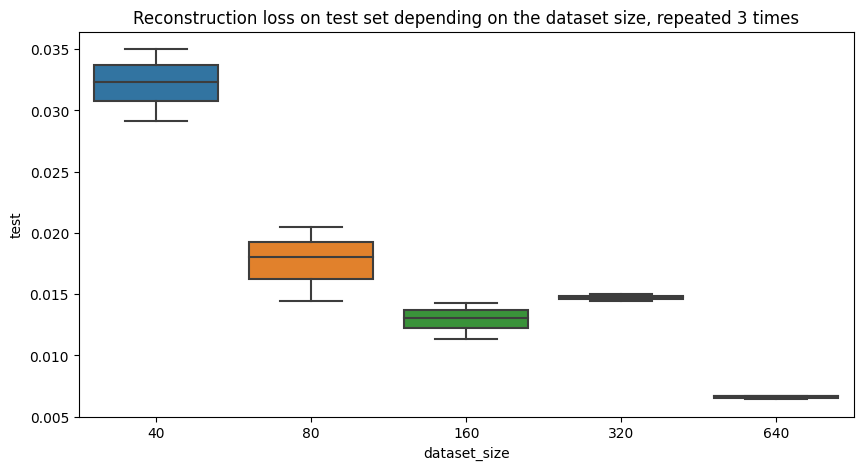

In [ ]:
plot_boxplot_variance_diff_dataset_sizes(df_results)

Comment: the best model has sometimes similar variance for scores when trained on datasets of different sizes, but the variance tends to get smaller for bigger sizes. Increasing the size of the training set with other parameters fixed increases the number of backpropagation steps which makes the model learn longer and be better. Increasing the dataset above some size will no longer bring any benefits.

<div style="color: green; font-weight: bold">Comment - different perspective:

- As reconstruction we thought about the reconstruction loss, so our chart shows differences in the loss between trained models. It would be more user friendly to show also the actual reconstructions, as provided in the sample solution.

</div>

### 1.3 Code distribution

1. Create and visualize a histogram of the code distribution. 

2. Fit a Gaussian mixture model (GMM) to the code distribution and use it to sample synthetic data. 

3. Comment on the quality of the generated data.

In [ ]:
X_train, X_test = get_moons_data(1000, 900)

model = Autoencoder(input_size=2, bottleneck_size=1, hidden_size=64, layers=2)

_ = train_autoencoder(model = model,
                            X_train = X_train,
                            X_test = X_test,
                            n_epochs = 100,
                            batch_size = 32,
                            learning_rate = 0.001)

Epoch 0/100: train_loss=0.7255, test_loss=0.7344
Epoch 10/100: train_loss=0.0395, test_loss=0.0379
Epoch 20/100: train_loss=0.0326, test_loss=0.0317
Epoch 30/100: train_loss=0.0266, test_loss=0.0266
Epoch 40/100: train_loss=0.0163, test_loss=0.0189
Epoch 50/100: train_loss=0.0116, test_loss=0.0158
Epoch 60/100: train_loss=0.0097, test_loss=0.0132
Epoch 70/100: train_loss=0.0092, test_loss=0.0125
Epoch 80/100: train_loss=0.0085, test_loss=0.0115
Epoch 90/100: train_loss=0.0081, test_loss=0.0112
Epoch 100/100: train_loss=0.0078, test_loss=0.0111


#### Ad 1. Create and visualize a histogram of the code distribution. 

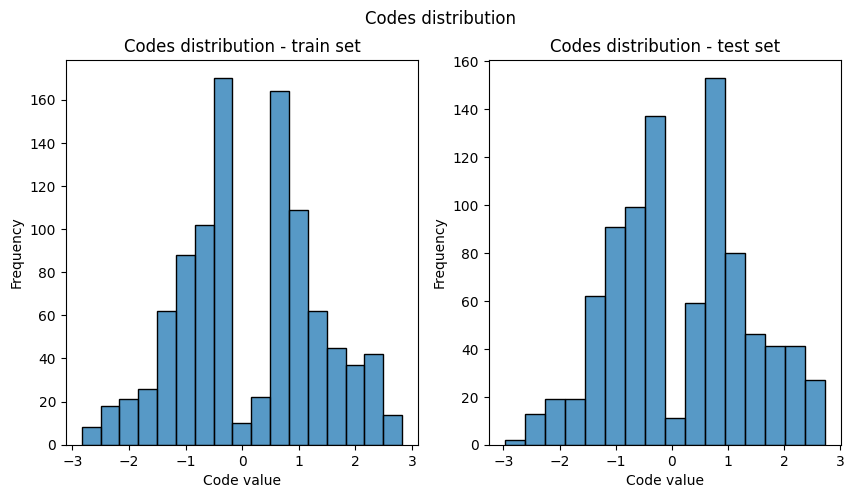

In [ ]:
with torch.no_grad():
    data = torch.from_numpy(X_train).float()
    codes_train = model.encode(data)
    codes_train = codes_train.numpy().flatten()
    data = torch.from_numpy(X_test).float()
    codes_test = model.encode(data)
    codes_test = codes_test.numpy().flatten()

df = pd.DataFrame({'codes': np.concatenate((codes_train, codes_test)), 'dataset': ['train']*len(codes_train) + ['test']*len(codes_test)})

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title('Codes distribution - train set')
ax[0].set_xlabel('Code value')
ax[0].set_ylabel('Frequency')
sns.histplot(data=df[df['dataset'] == 'train'], x='codes', ax=ax[0])
ax[1].set_title('Codes distribution - test set')
ax[1].set_xlabel('Code value')
ax[1].set_ylabel('Frequency')
sns.histplot(data=df[df['dataset'] == 'test'], x='codes', ax=ax[1])
fig.suptitle('Codes distribution')
plt.show()

#### Ad 2. Fit a Gaussian mixture model (GMM) to the code distribution and use it to sample synthetic data. 

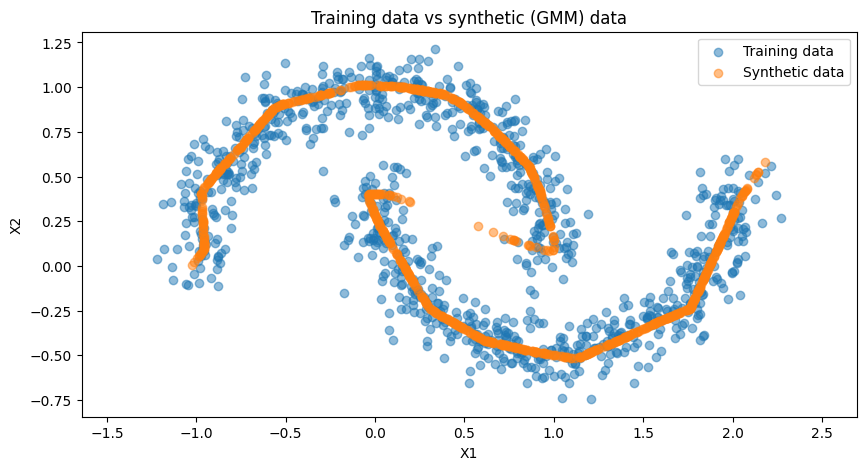

In [ ]:
gmm = GaussianMixture(n_components=6, random_state=RANDOM_STATE)
gmm.fit(codes_train.reshape(-1, 1))
codes_synthetic = gmm.sample(1000)[0].flatten()
new_data = np.array([model.decode(c.reshape(-1)).detach().numpy() for c in torch.from_numpy(codes_synthetic).float()])

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_title('Training data vs synthetic (GMM) data')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.axis('equal')
ax.scatter(X_train[:, 0], X_train[:, 1], alpha=0.5)
ax.scatter(new_data[:, 0], new_data[:, 1], alpha=0.5)
ax.legend(['Training data', 'Synthetic data'])
plt.show()

#### Ad 3. Comment on the quality of the generated data.

Codes distributions has a hole in the middle due to the disjoint nature of the original dataset. The GMM model is able to fit the distribution and the generated data is similar to data that our autoencoder can decode. Sometimes, the generated data is not visibly separated into two moons but it is connected in the middle, but it is still similar to what the decoder originally decoded - GMM successfully sampled from the codes distribution.

<div style="color: green; font-weight: bold">Comment - similar solution:

- Results are essentially equal.
</div>

### 1.4 Check autoencoder on test set with noise level 0.2

Check if the autoencoder still works (without retraining!) on a test set at noise level 0.2.

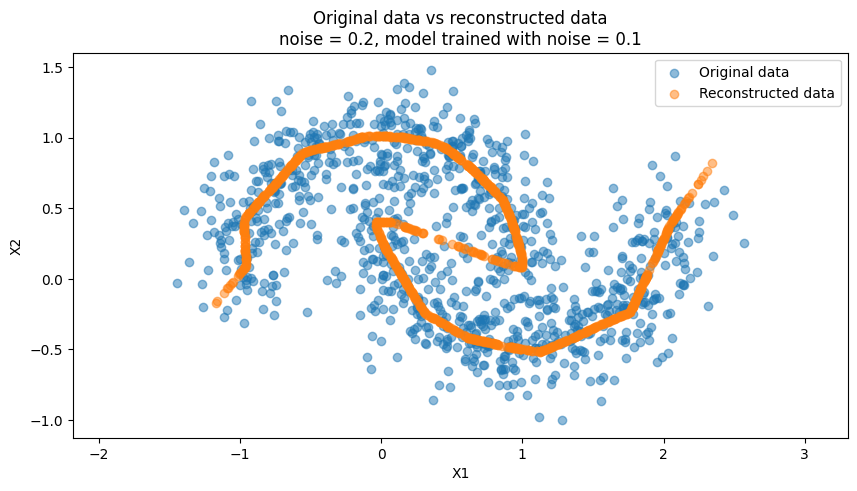

In [ ]:
X_train_02, _ = get_moons_data(1000, 900, noise=0.2)

with torch.no_grad():
    data = torch.from_numpy(X_train_02).float()
    recunstructed = model(data).numpy()

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_title('Original data vs reconstructed data\nnoise = 0.2, model trained with noise = 0.1')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.axis('equal')
ax.scatter(X_train_02[:, 0], X_train_02[:, 1], alpha=0.5)
ax.scatter(recunstructed[:, 0], recunstructed[:, 1], alpha=0.5)
ax.legend(['Original data', 'Reconstructed data'])
plt.show()

Comment: reconstruction seems to work, as before the reconstructed data is more line then data with noise, but the shape is similar.

<div style="color: green; font-weight: bold">Comment - similar solution:

- Results are essentially equal.

</div>

### 1.5 Retraining on noise level 0.2

Train an autoencoder with a training set at noise level 0.2

Comment on how the geometry of the reconstructed set changes.

In [ ]:
X_train_02, X_test_02 = get_moons_data(1000, 900, noise=0.2)

model = Autoencoder(input_size=2, bottleneck_size=1, hidden_size=64, layers=2)

_ = train_autoencoder(model = model,
                            X_train = X_train_02,
                            X_test = X_test_02,
                            n_epochs = 100,
                            batch_size = 32,
                            learning_rate = 0.001)

Epoch 0/100: train_loss=0.6618, test_loss=0.6772
Epoch 10/100: train_loss=0.0604, test_loss=0.0583
Epoch 20/100: train_loss=0.0505, test_loss=0.0489
Epoch 30/100: train_loss=0.0460, test_loss=0.0447
Epoch 40/100: train_loss=0.0426, test_loss=0.0421
Epoch 50/100: train_loss=0.0389, test_loss=0.0399
Epoch 60/100: train_loss=0.0361, test_loss=0.0386
Epoch 70/100: train_loss=0.0347, test_loss=0.0370
Epoch 80/100: train_loss=0.0336, test_loss=0.0357
Epoch 90/100: train_loss=0.0326, test_loss=0.0348
Epoch 100/100: train_loss=0.0311, test_loss=0.0333


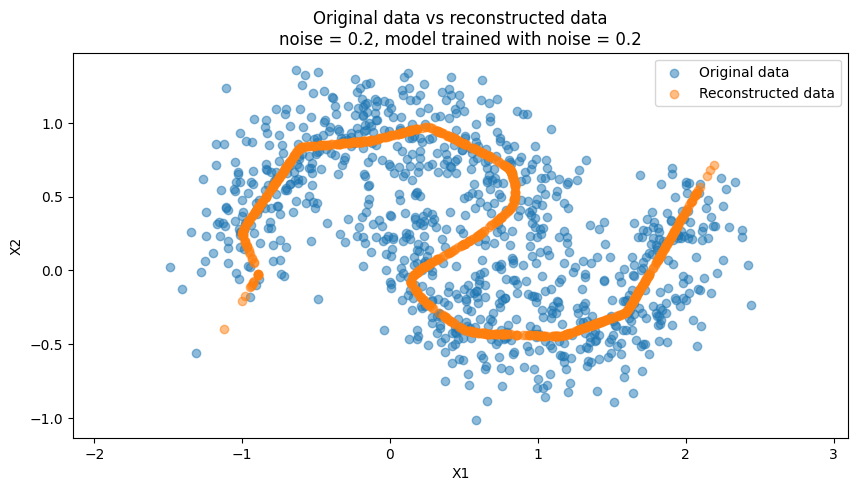

In [ ]:
with torch.no_grad():
    data = torch.from_numpy(X_test_02).float()
    reconstructed = model(data).numpy()

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_title('Original data vs reconstructed data\nnoise = 0.2, model trained with noise = 0.2')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.axis('equal')
ax.scatter(X_test_02[:, 0], X_test_02[:, 1], alpha=0.5)
ax.scatter(reconstructed[:, 0], reconstructed[:, 1], alpha=0.5)
ax.legend(['Original data', 'Reconstructed data'])
plt.show()

Comment: the reconstructed data is similar to earlier but the moons are clearly connected in the middle and less distinct. There is also a strange end at the end of one of the moons.

<div style="color: green; font-weight: bold">Comment - similar solution:

- Results are a bit different, but the general tendency is similar.
</div>

## 2. Two-dimensional data without bottleneck

We continue with the two moons dataset, but this time bottleneck size 2.

Since training now lacks the regularizing effect of the lossy compression (which enforces the codes to focus on the important data features), we need an additional loss term. 

We use the maximum mean discrepancy (MMD) between 
- the code distribution (i.e. the push-forward through the encoder)
- and a 2-dimensional standard normal. 

This loss pulls the code distribution towards the standard normal, so that we can later generate synthetic data by sampling from the standard normal and transform the samples through the decoder. 

The kernel for MMD shall be a 
- sum of squared exponentials 
- or inverse multi-quadratics at multiple bandwidths (the number and values of the bandwidths are hyperparameters -**use three to seven bandwidths** such that each value is twice the next smaller one). 

The training loss is a *weighted sum of the squared reconstruction error and the MMD*, with the weight being yet
another hyperparameter.

In [ ]:
def mmd(dataset_1, dataset_2, bandwidth):
    """
    Function that calculates squared MMD metric.

    Args:
        dataset_1 (torch.Tensor): array of original points.
        dataset_2 (torch.Tensor): array of reconstructed points.
        bandwidth (float): bandwidth of kernel.
    """
    
    M = len(dataset_1)
    part_1 = 0

    N = len(dataset_2)
    part_2 = 0
    # To make it possible for MMD to run on Tensors, we changed the commented code into torch.sum
    
    # for i in range(N):
    #     for j in range(N):
    #         part_2 += mmd_kernel_squared_exponential(dataset_2[i], dataset_2[j], bandwidth)
    part_2 = torch.sum(torch.exp(-torch.cdist(dataset_2, dataset_2, p=2)**2 / (2 * bandwidth)))
    part_2 /= N * (N - 1)

    part_3 = 0
    # for i in range(M):
    #     for j in range(N):
    #         part_3 += mmd_kernel_squared_exponential(dataset_1[i], dataset_2[j], bandwidth)
    part_3 = torch.sum(torch.exp(-torch.cdist(dataset_1, dataset_2, p=2)**2 / (2 * bandwidth)))
    part_3 *= 2 / (M * N)

    mmd_square = part_1 + part_2 - part_3

    return mmd_square

# IMPLEMENTED USING MATRICES ABOVE

# def mmd_kernel_squared_exponential(x,y,h):
#     """
#     Function that calculates squared exponential kernel.

#     Args:
#         x (torch.Tensor): point.
#         y (torch.Tensor): point.
#         h (float): bandwidth of kernel.
#     """
#     return torch.exp(-1 * torch.norm(x - y) ** 2 / (2 * h) )

We decided to use the autoencoder from task 1 (with bottleneck_size=2) with different way of computing the loss.

In [ ]:
# new function to calculate loss

def calculate_loss(criterion, output, output_encoder, data, weight, bandwidth):
    np.random.seed(RANDOM_STATE)
    gen_2dim = np.random.normal(size=[1000, 2])
    gen_2dim = torch.from_numpy(gen_2dim).float()
    mmd_cal=mmd(gen_2dim, output_encoder, bandwidth)
    loss_part1 = criterion(output, data)
    loss_new=weight*loss_part1+(1-weight)*mmd_cal
    return loss_new

Implement a new function `train_mmd_autoencoder()` and train the model at noise level 0.1.

In [ ]:
def train_mmd_autoencoder(model, X_train, X_test, n_epochs, batch_size, learning_rate=0.001, size_of_the_training_set=-1, weight=0.5, bandwidth=0.5):
    """
    Args:
        model (nn.Module): the autoencoder model
        X_train (np.ndarray): the training data
        X_test (np.ndarray): the test data
        n_epochs (int): the number of training epochs
        batch_size (int): the batch size
        learning_rate (float): the learning rate
        size_of_the_training_set (int): subset of the training set to use (default: -1, i.e. use the whole training set)
        weight (float): the weight of the reconstruction loss in the total loss
        bandwidth (float): the bandwidth of the kernel in the MMD loss
    """
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    test_losses = []

    X_train = X_train[:size_of_the_training_set]
    
    data_train = torch.from_numpy(X_train).float()
    data_test = torch.from_numpy(X_test).float()

    # loss before training
    with torch.no_grad():
        output_encoder=model.encoder(data_train)
        outputs=model.decoder(output_encoder)
        loss=calculate_loss(criterion, outputs, output_encoder, data_train, weight, bandwidth)
        train_losses.append(loss.item())
        output_encoder=model.encoder(data_test)
        outputs=model.decoder(output_encoder)
        loss=calculate_loss(criterion, outputs, output_encoder, data_test, weight, bandwidth)
        test_losses.append(loss.item())
    print(f"Epoch 0/{n_epochs}: train_loss={train_losses[-1]:.4f}, test_loss={test_losses[-1]:.4f}")

    # trainning
    for epoch in range(n_epochs):
        train_loss = 0
        test_loss = 0
        for i in range(0, len(X_train), batch_size):
            data = data_train[i:i+batch_size]
            optimizer.zero_grad()
            output_encoder=model.encoder(data)
            outputs=model.decoder(output_encoder)
            loss=calculate_loss(criterion, outputs, output_encoder, data, weight, bandwidth)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * len(data)
        train_loss /= len(X_train)
        train_losses.append(train_loss)
        with torch.no_grad():
            for i in range(0, len(X_test), batch_size):
                data = data_test[i:i+batch_size]
                output_encoder=model.encoder(data)
                outputs=model.decoder(output_encoder)
                loss=calculate_loss(criterion, outputs, output_encoder, data, weight, bandwidth)
                test_loss += loss.item() * len(data)
            test_loss /= len(X_test)
            test_losses.append(test_loss)
        if (epoch+1) % (n_epochs//10+1) == 0:
            print(f"Epoch {epoch+1}/{n_epochs}: train_loss={train_loss:.4f}, test_loss={test_loss:.4f}")
    df = pd.DataFrame({'train': train_losses, 'test': test_losses, 'epoch': list(range(n_epochs+1))})
    return df

Training of the models for four various bandwidths and two various weights: 0.05 $(0.05*loss+0.95*mmd)$ and 0.95 $(0.95*loss+0.05*mmd)$.

In [ ]:
X_train, X_test = get_moons_data(200, 200) #default value of parameter noise is 0.1

common_training_parameters = {
    'n_epochs': 1000,
    'batch_size': 200,
    'learning_rate': 0.001
}

In [ ]:
model_b_1_w_005 = Autoencoder(input_size=2, bottleneck_size=2, hidden_size=64, layers=2)

df_losses_b_1_w_005 = train_mmd_autoencoder(model = model_b_1_w_005,
                            X_train = X_train,
                            X_test = X_test,
                            **common_training_parameters,
                            weight=0.05,
                            bandwidth=1)

model_b_05_w_005 = Autoencoder(input_size=2, bottleneck_size=2, hidden_size=64, layers=2)

df_losses_b_05_w_005 = train_mmd_autoencoder(model = model_b_05_w_005,
                            X_train = X_train,
                            X_test = X_test,
                            **common_training_parameters,
                            weight=0.05,
                            bandwidth=0.5)

model_b_025_w_005 = Autoencoder(input_size=2, bottleneck_size=2, hidden_size=64, layers=2)

df_losses_b_025_w_005 = train_mmd_autoencoder(model = model_b_025_w_005,
                            X_train = X_train,
                            X_test = X_test,
                            **common_training_parameters,
                            weight=0.05,
                            bandwidth=0.25)

model_b_0125_w_005 = Autoencoder(input_size=2, bottleneck_size=2, hidden_size=64, layers=2)

df_losses_b_0125_w_005 = train_mmd_autoencoder(model = model_b_0125_w_005,
                            X_train = X_train,
                            X_test = X_test,
                            **common_training_parameters,
                            weight=0.05,
                            bandwidth=0.125)

Epoch 0/1000: train_loss=0.0346, test_loss=0.0344
Epoch 101/1000: train_loss=-0.3143, test_loss=-0.3146
Epoch 202/1000: train_loss=-0.3170, test_loss=-0.3171
Epoch 303/1000: train_loss=-0.3181, test_loss=-0.3182
Epoch 404/1000: train_loss=-0.3190, test_loss=-0.3190
Epoch 505/1000: train_loss=-0.3196, test_loss=-0.3196
Epoch 606/1000: train_loss=-0.3199, test_loss=-0.3200
Epoch 707/1000: train_loss=-0.3202, test_loss=-0.3202
Epoch 808/1000: train_loss=-0.3204, test_loss=-0.3204
Epoch 909/1000: train_loss=-0.3205, test_loss=-0.3205
Epoch 0/1000: train_loss=0.3242, test_loss=0.3240
Epoch 101/1000: train_loss=-0.1790, test_loss=-0.1792
Epoch 202/1000: train_loss=-0.1831, test_loss=-0.1833
Epoch 303/1000: train_loss=-0.1857, test_loss=-0.1858
Epoch 404/1000: train_loss=-0.1886, test_loss=-0.1887
Epoch 505/1000: train_loss=-0.1906, test_loss=-0.1907
Epoch 606/1000: train_loss=-0.1915, test_loss=-0.1915
Epoch 707/1000: train_loss=-0.1919, test_loss=-0.1919
Epoch 808/1000: train_loss=-0.1921, 

In [ ]:
model_b_1_w_095 = Autoencoder(input_size=2, bottleneck_size=2, hidden_size=64, layers=2)

df_losses_b_1_w_095 = train_mmd_autoencoder(model = model_b_1_w_095,
                            X_train = X_train,
                            X_test = X_test,
                            **common_training_parameters,
                            weight=0.95,
                            bandwidth=1)

model_b_05_w_095 = Autoencoder(input_size=2, bottleneck_size=2, hidden_size=64, layers=2)

df_losses_b_05_w_095 = train_mmd_autoencoder(model = model_b_05_w_095,
                            X_train = X_train,
                            X_test = X_test,
                            **common_training_parameters,
                            weight=0.95,
                            bandwidth=0.5)

model_b_025_w_095 = Autoencoder(input_size=2, bottleneck_size=2, hidden_size=64, layers=2)

df_losses_b_025_w_095 = train_mmd_autoencoder(model = model_b_025_w_095,
                            X_train = X_train,
                            X_test = X_test,
                            **common_training_parameters,
                            weight=0.95,
                            bandwidth=0.25)

model_b_0125_w_095 = Autoencoder(input_size=2, bottleneck_size=2, hidden_size=64, layers=2)

df_losses_b_0125_w_095 = train_mmd_autoencoder(model = model_b_0125_w_095,
                            X_train = X_train,
                            X_test = X_test,
                            **common_training_parameters,
                            weight=0.95,
                            bandwidth=0.125)

Epoch 0/1000: train_loss=0.6344, test_loss=0.6317


Epoch 101/1000: train_loss=-0.0092, test_loss=-0.0095
Epoch 202/1000: train_loss=-0.0160, test_loss=-0.0161
Epoch 303/1000: train_loss=-0.0165, test_loss=-0.0165
Epoch 404/1000: train_loss=-0.0166, test_loss=-0.0166
Epoch 505/1000: train_loss=-0.0166, test_loss=-0.0166
Epoch 606/1000: train_loss=-0.0166, test_loss=-0.0166
Epoch 707/1000: train_loss=-0.0166, test_loss=-0.0166
Epoch 808/1000: train_loss=-0.0167, test_loss=-0.0167
Epoch 909/1000: train_loss=-0.0167, test_loss=-0.0167
Epoch 0/1000: train_loss=0.6283, test_loss=0.6258
Epoch 101/1000: train_loss=0.0021, test_loss=0.0010
Epoch 202/1000: train_loss=-0.0091, test_loss=-0.0092
Epoch 303/1000: train_loss=-0.0095, test_loss=-0.0095
Epoch 404/1000: train_loss=-0.0096, test_loss=-0.0096
Epoch 505/1000: train_loss=-0.0097, test_loss=-0.0097
Epoch 606/1000: train_loss=-0.0097, test_loss=-0.0097
Epoch 707/1000: train_loss=-0.0097, test_loss=-0.0098
Epoch 808/1000: train_loss=-0.0098, test_loss=-0.0098
Epoch 909/1000: train_loss=-0.0098

In [ ]:
# Sanity check that training with MSE loss only still works

model_b_025_w_1 = Autoencoder(input_size=2, bottleneck_size=2, hidden_size=64, layers=2)

df_losses_b_025_w_1 = train_mmd_autoencoder(model = model_b_025_w_1,
                            X_train = X_train,
                            X_test = X_test,
                            **common_training_parameters,
                            weight=1, #1*loss+0*mmd
                            bandwidth=0.25)

Epoch 0/1000: train_loss=0.7036, test_loss=0.7005
Epoch 101/1000: train_loss=0.0012, test_loss=0.0012
Epoch 202/1000: train_loss=0.0002, test_loss=0.0002
Epoch 303/1000: train_loss=0.0001, test_loss=0.0001
Epoch 404/1000: train_loss=0.0001, test_loss=0.0001
Epoch 505/1000: train_loss=0.0000, test_loss=0.0000
Epoch 606/1000: train_loss=0.0000, test_loss=0.0000
Epoch 707/1000: train_loss=0.0000, test_loss=0.0000
Epoch 808/1000: train_loss=0.0000, test_loss=0.0000
Epoch 909/1000: train_loss=0.0000, test_loss=0.0000


If we consider as the reconstruction error new loss (weighted sum of old loss and mmd), it is much less than the one we got with bottlenectk size 1. However, one of the reasons why it is so is the additional term in loss. As in the Assignment 1, we used the simplified MMD formula (which makes sense when using MMD for optimization, as we do here), which causes that the values of the MMD can be below zero. 

If we consider as the reconstruction error only the MSE loss, it is also much smaller then it was before.

Visualize the reconstructed vs. original data.

In [ ]:
def visualize_reconstructed_original_data(model, X_train, title='Original and reconstructed data'):
    with torch.no_grad():
        data = torch.from_numpy(X_train).float()
        outputs = model(data)
        outputs = outputs.numpy()
        outputs_encoder = model.encode(data)
        outputs_encoder = outputs_encoder.numpy()
        data = data.numpy()

    fig, ax = plt.subplots(1, 3, figsize=(7, 3))
    ax[0].scatter(data[:, 0], data[:, 1], alpha=0.5)
    ax[0].set_title('Original data')
    ax[0].set_xlabel('X1')
    ax[0].set_ylabel('X2')
    ax[0].axis('equal')
    ax[1].scatter(outputs_encoder[:, 0], outputs_encoder[:, 1], alpha=0.5)
    ax[1].set_title('Output from encoder')
    ax[1].set_xlabel('X1')
    ax[1].set_ylabel('')
    ax[1].axis('equal')
    ax[2].scatter(outputs[:, 0], outputs[:, 1], alpha=0.5)
    ax[2].set_title('Reconstructed data')
    ax[2].set_xlabel('X1')
    ax[2].set_ylabel('')
    ax[2].axis('equal')
    fig.suptitle(title, y=1.05)
    plt.show()

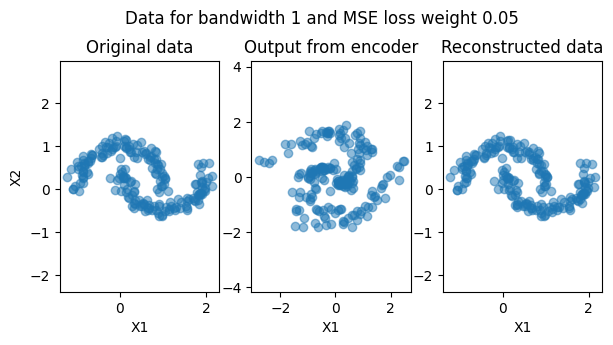

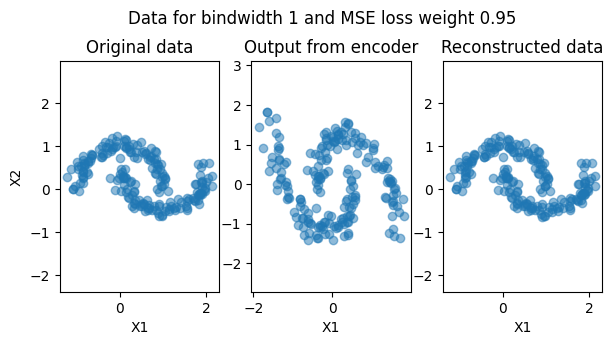

In [ ]:
visualize_reconstructed_original_data(model_b_1_w_005, X_train, 'Data for bandwidth 1 and MSE loss weight 0.05')
visualize_reconstructed_original_data(model_b_1_w_095, X_train, 'Data for bindwidth 1 and MSE loss weight 0.95')

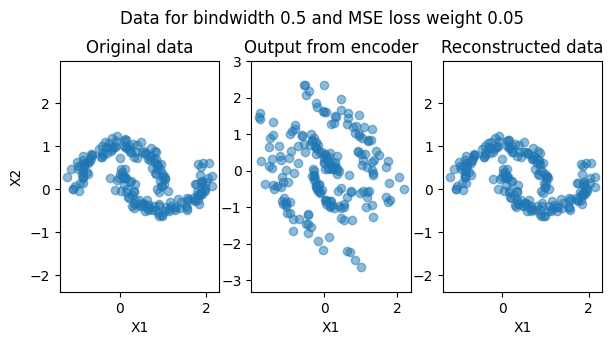

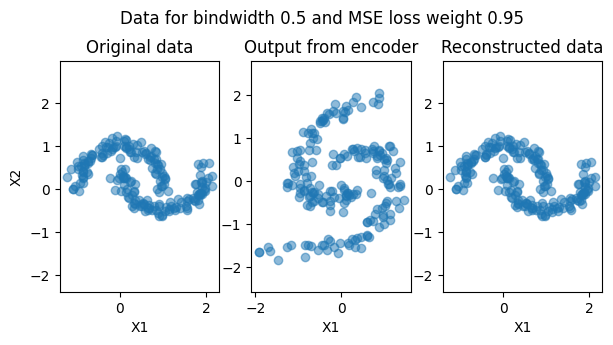

In [ ]:
visualize_reconstructed_original_data(model_b_05_w_005, X_train, 'Data for bindwidth 0.5 and MSE loss weight 0.05')
visualize_reconstructed_original_data(model_b_05_w_095, X_train, 'Data for bindwidth 0.5 and MSE loss weight 0.95')

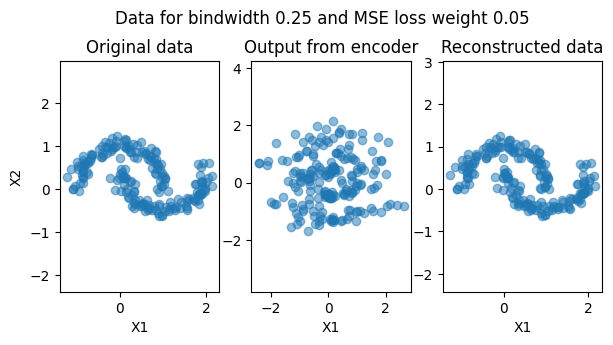

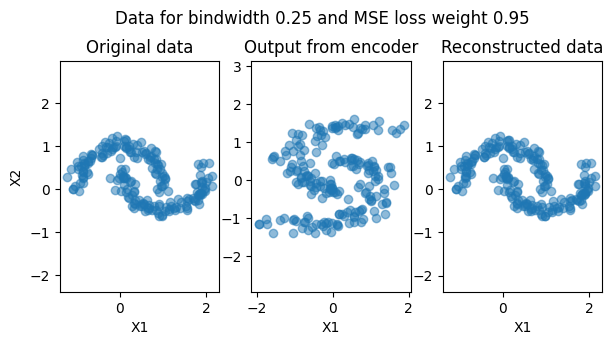

In [ ]:
visualize_reconstructed_original_data(model_b_025_w_005, X_train, 'Data for bindwidth 0.25 and MSE loss weight 0.05')
visualize_reconstructed_original_data(model_b_025_w_095, X_train, 'Data for bindwidth 0.25 and MSE loss weight 0.95')

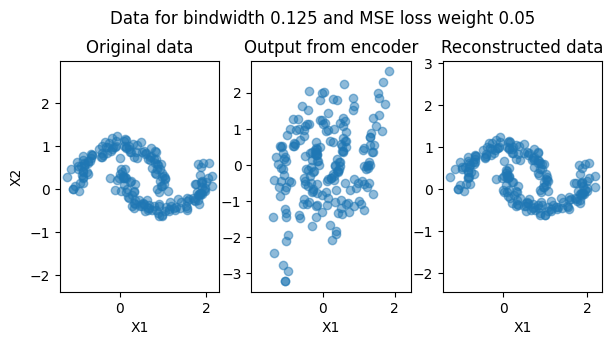

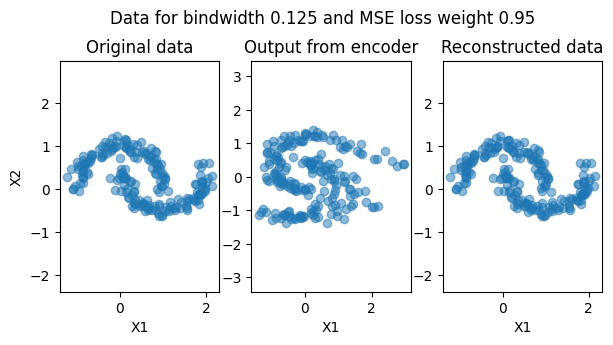

In [ ]:
visualize_reconstructed_original_data(model_b_0125_w_005, X_train, 'Data for bindwidth 0.125 and MSE loss weight 0.05')
visualize_reconstructed_original_data(model_b_0125_w_095, X_train, 'Data for bindwidth 0.125 and MSE loss weight 0.95')

Below we draw the code distribution only for one model.

In [ ]:
best_model = Autoencoder(input_size=2, bottleneck_size=2, hidden_size=128, layers=2)

_ = train_mmd_autoencoder(model = best_model,
                            X_train = X_train,
                            X_test = X_test,
                            n_epochs=200,
                            batch_size=200,
                            learning_rate=0.001,
                            weight=0.05,
                            bandwidth=0.1)

Epoch 0/200: train_loss=0.7368, test_loss=0.7368
Epoch 21/200: train_loss=-0.0269, test_loss=-0.0272
Epoch 42/200: train_loss=-0.0353, test_loss=-0.0354
Epoch 63/200: train_loss=-0.0381, test_loss=-0.0382
Epoch 84/200: train_loss=-0.0396, test_loss=-0.0397
Epoch 105/200: train_loss=-0.0404, test_loss=-0.0405
Epoch 126/200: train_loss=-0.0409, test_loss=-0.0410
Epoch 147/200: train_loss=-0.0413, test_loss=-0.0414
Epoch 168/200: train_loss=-0.0417, test_loss=-0.0417
Epoch 189/200: train_loss=-0.0419, test_loss=-0.0420


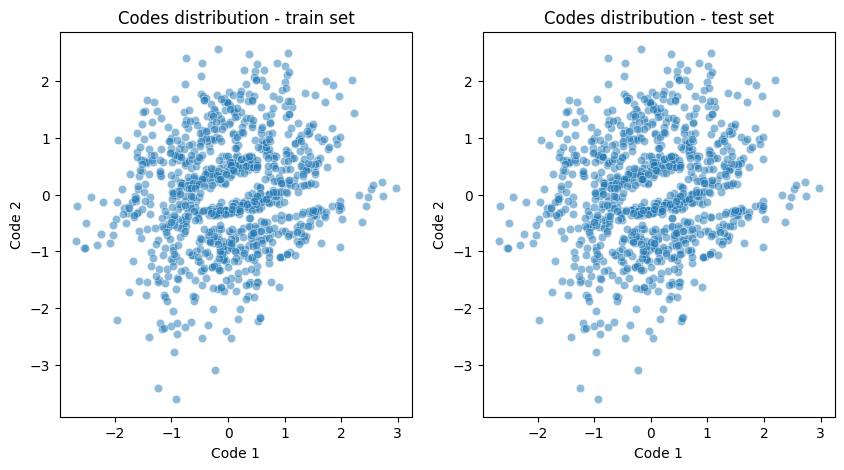

In [ ]:
model = best_model
X_train, X_test = get_moons_data(1000, 1000)
with torch.no_grad():
    data = torch.from_numpy(X_train).float()
    codes_train = model.encode(data)
    codes_train = codes_train.numpy()
    data = torch.from_numpy(X_test).float()
    codes_test = model.encode(data)
    codes_test = codes_test.numpy()

df = pd.DataFrame({'Code 1': np.concatenate((codes_train, codes_test))[:, 0],
                     'Code 2': np.concatenate((codes_train, codes_test))[:, 1],
                    'dataset': ['train']*len(codes_train) + ['test']*len(codes_test)})

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title('Codes distribution - train set')
sns.scatterplot(data=df[df['dataset'] == 'train'], x='Code 1', y='Code 2', ax=ax[0], alpha=0.5)
ax[1].set_title('Codes distribution - test set')
sns.scatterplot(data=df[df['dataset'] == 'test'], x='Code 1', y='Code 2', ax=ax[1], alpha=0.5)
plt.show()
fig.suptitle('Codes distribution')
plt.show()

Generate synthetic data by passing standard normal samples through the decoder and visualize their quality. 

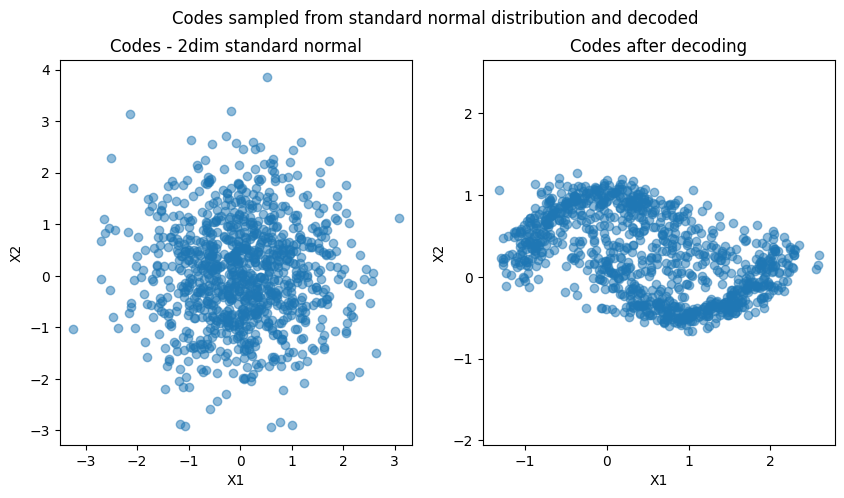

In [ ]:
with torch.no_grad():
    np.random.seed(42)
    data = np.random.normal(size=[1000, 2])
    outputs = model.decode(torch.tensor(data, dtype=torch.float32))
    outputs = outputs.numpy()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(data[:, 0], data[:, 1], alpha=0.5)
ax[0].set_title('Codes - 2dim standard normal')
ax[0].set_xlabel('X1')
ax[0].set_ylabel('X2')
ax[0].axis('equal')
ax[1].scatter(outputs[:, 0], outputs[:, 1], alpha=0.5)
ax[1].set_title('Codes after decoding')
ax[1].set_xlabel('X1')
ax[1].set_ylabel('X2')
ax[1].axis('equal')
fig.suptitle('Codes sampled from standard normal distribution and decoded')
plt.show()

Comments:
- due to the use the weighted sum of loss and MMD the results differ from the ones we got before.
- not all settings (`bandwidth` and `weight`) give the same results. As can be seen on the comparison of original and reconstructed data, in most cases they are really similar. This means that the decoder did its job and learned how to decode, what it got from encoder, no matter what it was.
- the encoder was not always able to learn at least a bit of what we wanted it to learn. 
- however, as we can see on the code distribution from the best model, for both train and test data look similar to the standard normal.
- when we gave the model sample from standard normal the decoder was able to change it, and we can see shape similar to the moons dataset.

<div style="color: green; font-weight: bold">Comment - also valid version:

- In the assignment there was an alternative to ResNet which is implemented in the sample solution - "Use the autoencoder from task 1 (with bottleneck_size=2) or implement a residual network (ResNet)". We decided to use the autoencoder from task 1.
- We also chose from the assignement to use kernel for MMD as a sum of squared exponentials and in the sample solution there is inverse multi-quadratic used.
- For MMD we also, as in the sample solution, implemented it with the use of torch library, to make it faster.
- We have a separate function to calculate the loss after the changes with MMD, but the idea is equal to the one from sample solution.
- Differences in the training loop are the same as in task 1.
- The experiments are also a bit different - we experiment with less combinations of hyperparameters, but still wrote conclusions based on the results we got.
- The conclustions are a bit different from the ones from sample solution, but we used different model, so our answers are still valid alternative.
</div>

## 3. Higher-dimensional data

In [ ]:
def get_digit_data(test_size=0.3, random_state=RANDOM_STATE):
    digits = load_digits()
    X = digits.data
    y = digits.target
    digits_X_train, digits_X_test, digits_y_train, digits_y_test = train_test_split(X, y,test_size=0.3, random_state=random_state)
    return digits_X_train, digits_X_test, digits_y_train, digits_y_test
digits_X_train, digits_X_test, digits_y_train, digits_y_test = get_digit_data()

In [ ]:
def plot_digits(data, title):
    data_processed = data.copy()
    data_processed[data_processed < 0] = 0
    data_processed[data_processed > 16] = 16

    fig, ax = plt.subplots(10, 10, figsize=(5,5),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data_processed[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
    plt.suptitle(title)
    plt.show()

### Test bottleneck sizes 2, 4 and 8. Visualize and measure the quality of the reconstructions as a function of bottleneck size. Can you still recognize the digit labels in the reconstructed data? 

In [ ]:
digits_X_train, digits_X_test, digits_y_train, digits_y_test = get_digit_data()

In [ ]:
# test bottleneck size 2
model_b_2 = Autoencoder(input_size=64, bottleneck_size=2, hidden_size=64, layers=2)

df_losses_b_2 = train_autoencoder(model = model_b_2,
                            X_train = digits_X_train,
                            X_test = digits_X_test,
                            n_epochs = 100,
                            batch_size = 32,
                            learning_rate = 0.001)

mmd_b_2=mmd(digits_X_test, model_b_2(torch.tensor(digits_X_test, dtype=torch.float32)).detach().numpy(), 0.5)

Epoch 0/100: train_loss=60.0667, test_loss=59.6756
Epoch 10/100: train_loss=14.6434, test_loss=14.6447
Epoch 20/100: train_loss=12.5943, test_loss=12.7331
Epoch 30/100: train_loss=11.7935, test_loss=12.0521
Epoch 40/100: train_loss=11.1724, test_loss=11.3886
Epoch 50/100: train_loss=10.8755, test_loss=11.2429
Epoch 60/100: train_loss=10.6710, test_loss=11.0777
Epoch 70/100: train_loss=10.4950, test_loss=10.9583
Epoch 80/100: train_loss=10.3058, test_loss=10.7614
Epoch 90/100: train_loss=10.1289, test_loss=10.7076
Epoch 100/100: train_loss=9.9980, test_loss=10.6523


In [ ]:
# test bottleneck size 4
model_b_4 = Autoencoder(input_size=64, bottleneck_size=4, hidden_size=64, layers=2)

df_losses_b_4 = train_autoencoder(model = model_b_4,
                            X_train = digits_X_train,
                            X_test = digits_X_test,
                            n_epochs = 100,
                            batch_size = 32,
                            learning_rate = 0.001)

mmd_b_4=mmd(digits_X_test, model_b_4(torch.tensor(digits_X_test, dtype=torch.float32)).detach().numpy(), 0.5)

Epoch 0/100: train_loss=60.2785, test_loss=59.8864
Epoch 10/100: train_loss=9.8564, test_loss=9.7897
Epoch 20/100: train_loss=8.3552, test_loss=8.5156
Epoch 30/100: train_loss=7.4494, test_loss=7.6745
Epoch 40/100: train_loss=6.8319, test_loss=7.1519
Epoch 50/100: train_loss=6.5081, test_loss=6.8818
Epoch 60/100: train_loss=6.2314, test_loss=6.7112
Epoch 70/100: train_loss=6.1135, test_loss=6.5909
Epoch 80/100: train_loss=5.8602, test_loss=6.4637
Epoch 90/100: train_loss=5.7322, test_loss=6.3658
Epoch 100/100: train_loss=5.6098, test_loss=6.3251


In [ ]:
# test bottleneck size 8
model_b_8 = Autoencoder(input_size=64, bottleneck_size=8, hidden_size=64, layers=2)

df_losses_b_8 = train_autoencoder(model = model_b_8,
                            X_train = digits_X_train,
                            X_test = digits_X_test,
                            n_epochs = 100,
                            batch_size = 32,
                            learning_rate = 0.001)

mmd_b_8=mmd(digits_X_test, model_b_8(torch.tensor(digits_X_test, dtype=torch.float32)).detach().numpy(), 0.5)

Epoch 0/100: train_loss=60.0366, test_loss=59.6551
Epoch 10/100: train_loss=7.3282, test_loss=7.2673
Epoch 20/100: train_loss=5.4390, test_loss=5.5529
Epoch 30/100: train_loss=4.6336, test_loss=4.7412
Epoch 40/100: train_loss=4.1930, test_loss=4.3793
Epoch 50/100: train_loss=3.9155, test_loss=4.1450
Epoch 60/100: train_loss=3.7006, test_loss=3.9542
Epoch 70/100: train_loss=3.5409, test_loss=3.8371
Epoch 80/100: train_loss=3.4273, test_loss=3.7368
Epoch 90/100: train_loss=3.3087, test_loss=3.6879
Epoch 100/100: train_loss=3.2257, test_loss=3.6276


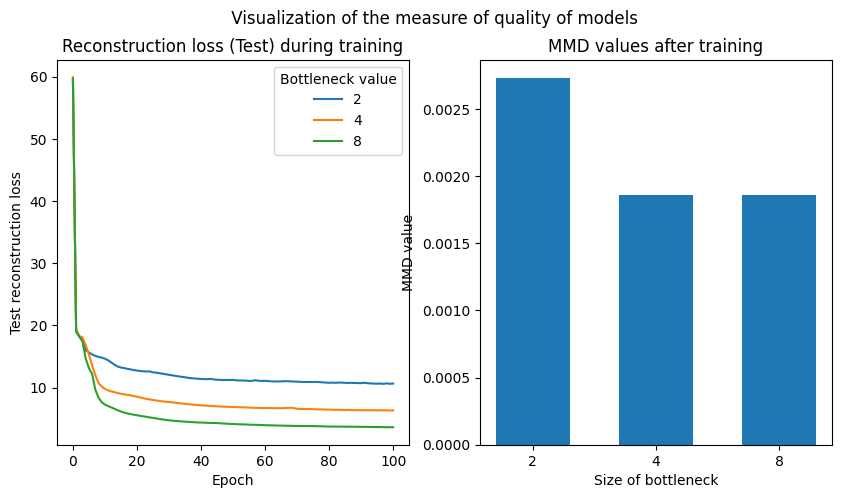

In [ ]:
# Visualize the results of the measure
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))


sns.lineplot(data=df_losses_b_2, x='epoch', y='test', ax=ax[0], label="2")
sns.lineplot(data=df_losses_b_4, x='epoch', y='test', ax=ax[0], label="4")
sns.lineplot(data=df_losses_b_8, x='epoch', y='test', ax=ax[0], label="8")
ax[0].set_title("Reconstruction loss (Test) during training")
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Test reconstruction loss')
ax[0].legend(title='Bottleneck value')

size_bottleneck=[2,4,8]
mmd_value=[mmd_b_2, mmd_b_4, mmd_b_8]
bar_positions = np.arange(len(size_bottleneck))
ax[1].bar(bar_positions, mmd_value, width = 0.6)
ax[1].set_xlabel('Size of bottleneck')
ax[1].set_ylabel('MMD value')
ax[1].set_xticks(bar_positions, size_bottleneck)
ax[1].set_title("MMD values after training")
fig.suptitle(' Visualization of the measure of quality of models')
plt.show()

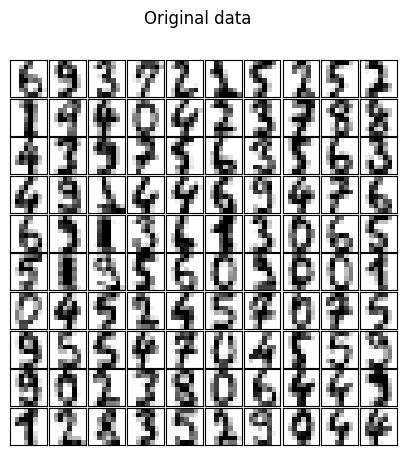

In [ ]:
plot_digits(digits_X_test, "Original data")

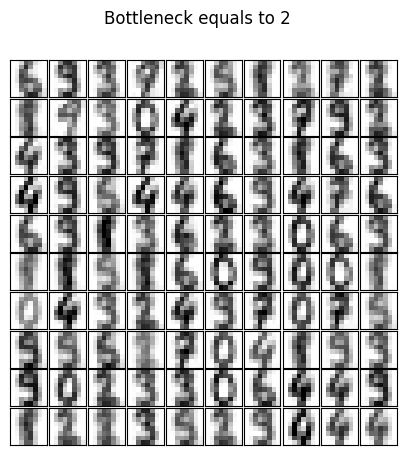

In [ ]:
plot_digits(model_b_2(torch.tensor(digits_X_test, dtype=torch.float32)).detach().numpy(), "Bottleneck equals to 2")

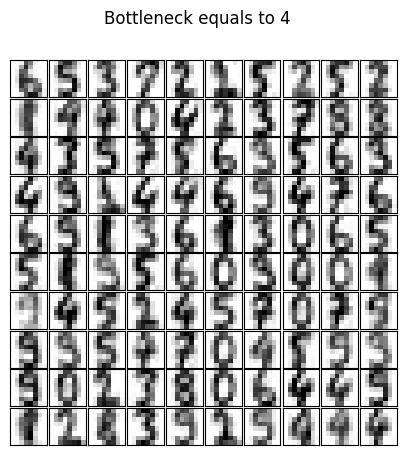

In [ ]:
plot_digits(model_b_4(torch.tensor(digits_X_test, dtype=torch.float32)).detach().numpy(), "Bottleneck equals to 4")

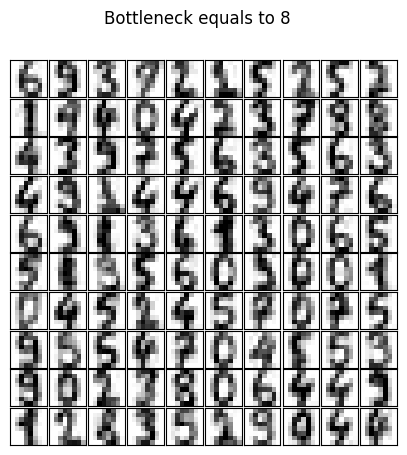

In [ ]:
plot_digits(model_b_8(torch.tensor(digits_X_test, dtype=torch.float32)).detach().numpy(), "Bottleneck equals to 8")

Comment: for bottleneck equals to 2, we can still recognize the digits, however they are not that easily visible as in original data. For the bottleneck equals 4 or 8, the reconstructed digits are closer to the original as is visible both by looking the digits, and by looking at the MSE loss during training. MMD shows that bottleneck 4 and 8 are better than bottleneck 2.

#### Train a sklearn.ensemble.RandomForestClassifier on the training data and use it to classify the test set and the reconstructed test set. Check if the predicted labels are the same for originals and reconstructions.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=RANDOM_STATE)
rfc.fit(digits_X_train, digits_y_train)
y_pred_test=rfc.predict(digits_X_test)
y_pred_b_2= rfc.predict(model_b_2(torch.tensor(digits_X_test, dtype=torch.float32)).detach().numpy())
y_pred_b_4= rfc.predict(model_b_4(torch.tensor(digits_X_test, dtype=torch.float32)).detach().numpy())
y_pred_b_8= rfc.predict(model_b_8(torch.tensor(digits_X_test, dtype=torch.float32)).detach().numpy())

In [ ]:
column_titles=['Test data', 'Bottleneck 2', 'Bottleneck 4', 'Bottleneck 8']
df_results=pd.DataFrame(data=np.column_stack((y_pred_test, y_pred_b_2, y_pred_b_4, y_pred_b_8)), columns=column_titles)
df_results.head()

,Test data,Bottleneck 2,Bottleneck 4,Bottleneck 8
0,6,6,6,6
1,9,9,5,9
2,3,3,3,3
3,7,7,7,7
4,2,2,2,2


In [ ]:
#check how many distinctive values were predicted for bottleneck 2, 4 and 8
print(np.unique(y_pred_b_2, return_counts=True))
print(np.unique(y_pred_b_4, return_counts=True))
print(np.unique(y_pred_b_8, return_counts=True))

(array([0, 1, 2, 3, 4, 6, 7, 8, 9]), array([53,  8, 75, 62, 60, 64, 65, 65, 88], dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([50, 37, 48, 52, 62, 56, 50, 60, 63, 62], dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([52, 41, 47, 47, 62, 52, 55, 57, 67, 60], dtype=int64))


According to the results, bottleneck 2 failed to reconstruct digit 5, others are fine.

In [ ]:
print(f"Percent of the same labels for orignal and reconstructed data for bottleneck equals to 2: {np.round(sum(y_pred_test==y_pred_b_2)/len(y_pred_b_2), 2)*100}%.")
print(f"Percent of the same labels for orignal and reconstructed data for bottleneck equals to 4: {np.round(sum(y_pred_test==y_pred_b_4)/len(y_pred_b_4), 2)*100}%.")
print(f"Percent of the same labels for orignal and reconstructed data for bottleneck equals to 8: {np.round(sum(y_pred_test==y_pred_b_8)/len(y_pred_b_8), 2)*100}%.")

Percent of the same labels for orignal and reconstructed data for bottleneck equals to 2: 70.0%.
Percent of the same labels for orignal and reconstructed data for bottleneck equals to 4: 89.0%.
Percent of the same labels for orignal and reconstructed data for bottleneck equals to 8: 91.0%.


### For bottleneck size 2, 
- visualize the code distribution 
- and color the points according to their labels.

Do you observe interesting structure in the colored code distribution? 

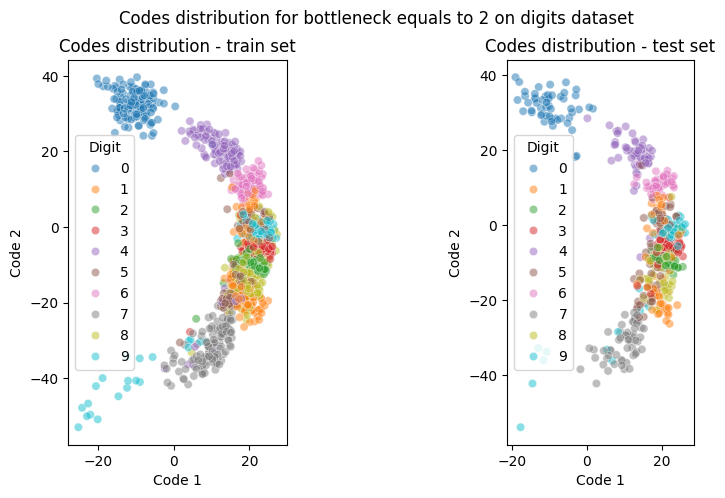

In [ ]:
model = model_b_2
with torch.no_grad():
    data = torch.from_numpy(digits_X_train).float()
    codes_train = model.encode(data)
    codes_train = codes_train.numpy()
    data = torch.from_numpy(digits_X_test).float()
    codes_test = model.encode(data)
    codes_test = codes_test.numpy()

df = pd.DataFrame({'Code 1': np.concatenate((codes_train, codes_test))[:, 0],
                     'Code 2': np.concatenate((codes_train, codes_test))[:, 1],
                     'Digit': np.concatenate((digits_y_train, digits_y_test)),
                    'dataset': ['train']*len(codes_train) + ['test']*len(codes_test)})

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title('Codes distribution - train set')
sns.scatterplot(data=df[df['dataset'] == 'train'], x='Code 1', y='Code 2', ax=ax[0], alpha=0.5, hue='Digit', palette='tab10')
# set to equal the axes
ax[0].set_aspect('equal')

ax[1].set_title('Codes distribution - test set')
sns.scatterplot(data=df[df['dataset'] == 'test'], x='Code 1', y='Code 2', ax=ax[1], alpha=0.5, hue='Digit', palette='tab10')
ax[1].set_aspect('equal')
fig.suptitle('Codes distribution for bottleneck equals to 2 on digits dataset')
plt.show()

Comment: Codes are distributed in a strange way so that a structure similar to a bow appeared. From the top they can be ordered in the following way: 0, 4, 6, (mixed 8, 9, 5), 3, 2, 1, 7 and 9.
Digit 0 is the most distinct one from the rest. 4, 6 and 7 are also quite distinct. 9 is present in 2 places - mixed with 8 and 5 and in a separate group aside. The rest are mixed in the middle.

Fit a Gaussian mixture model (GMM) to the code distributions for all bottleneck sizes and generate synthetic digits.

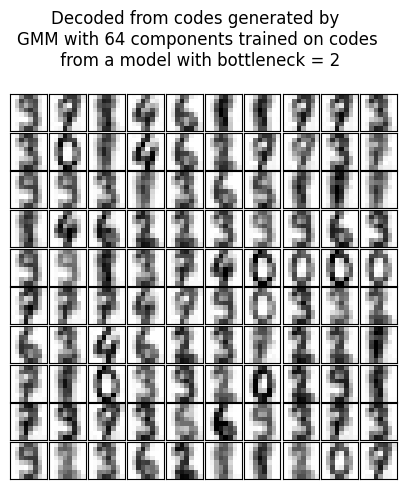

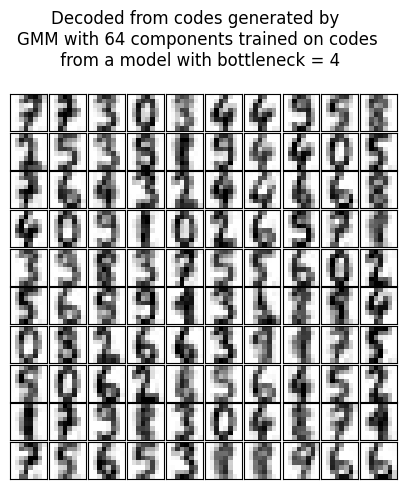

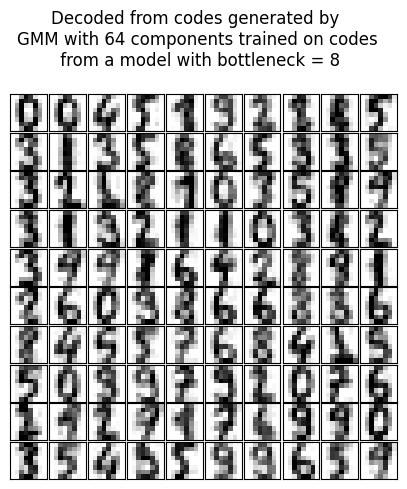

In [ ]:
from sklearn.mixture import GaussianMixture

def generate_synthetic_data(model, X_train, n_components, random_state=RANDOM_STATE):
    with torch.no_grad():
        data = torch.from_numpy(X_train).float()
        codes_train = model.encode(data)
        codes_train = codes_train.numpy()
    gmm = GaussianMixture(n_components=n_components, random_state=random_state)
    gmm.fit(codes_train)
    codes_synthetic = gmm.sample(1000)[0]
    codes_synthetic = codes_synthetic[np.random.permutation(len(codes_synthetic))]
    new_data = np.array([model.decode(c.reshape(-1)).detach().numpy() for c in torch.from_numpy(codes_synthetic).float()])
    return new_data

c_components = 64
new_data_b_2 = generate_synthetic_data(model_b_2, digits_X_train, c_components)
new_data_b_4 = generate_synthetic_data(model_b_4, digits_X_train, c_components)
new_data_b_8 = generate_synthetic_data(model_b_8, digits_X_train, c_components)

def plot_digits(data, title):
    data_processed = data.copy()
    data_processed[data_processed < 0] = 0
    data_processed[data_processed > 16] = 16

    fig, ax = plt.subplots(10, 10, figsize=(5,5),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data_processed[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
    plt.suptitle(title, y=1.05)
    plt.show()

plot_digits(new_data_b_2, f"Decoded from codes generated by \nGMM with {c_components} components trained on codes\n from a model with bottleneck = 2")
plot_digits(new_data_b_4, f"Decoded from codes generated by \nGMM with {c_components} components trained on codes\n from a model with bottleneck = 4")
plot_digits(new_data_b_8, f"Decoded from codes generated by \nGMM with {c_components} components trained on codes\n from a model with bottleneck = 8")

Visually inspect the quality of the synthetic data. Can you recognize their labels? 

Answer: Yes, mostly we can recognize the labels, especially for data decoded from codes that were sampled by a GMM with 64 components that was trained on codes distribution of the original model with bottleneck size equal to 8.

Check the performance of the classifier on the synthetic data. Does it agree with what you see?

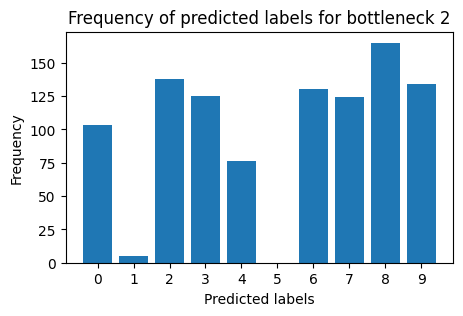

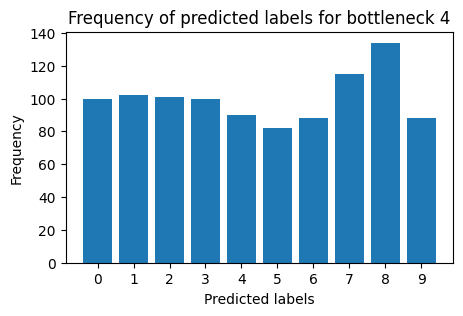

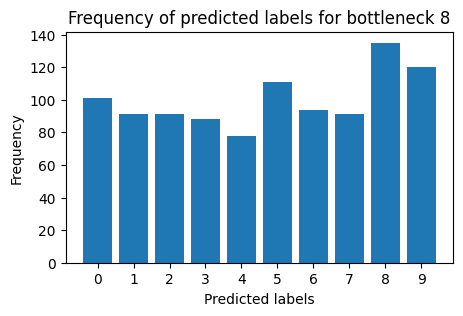

In [ ]:
y_pred_b_2= rfc.predict(new_data_b_2)
y_pred_b_4= rfc.predict(new_data_b_4)
y_pred_b_8= rfc.predict(new_data_b_8)

def plot_frequency_predicted_labels(y_pred, title):
    unique, counts = np.unique(y_pred, return_counts=True)
    counts_dict = dict(zip(unique, counts))
    for i in range(10):
        if i not in counts_dict.keys():
            counts_dict[i] = 0
    counts = list(counts_dict.values())
    unique = list(counts_dict.keys())
    
    plt.rcParams["figure.figsize"] = (5,3)
    plt.bar(unique, counts)
    plt.xticks(np.arange(10))
    plt.title(title)
    plt.xlabel('Predicted labels')
    plt.ylabel('Frequency')
    plt.show()
    
plot_frequency_predicted_labels(y_pred_b_2, 'Frequency of predicted labels for bottleneck 2')
plot_frequency_predicted_labels(y_pred_b_4, 'Frequency of predicted labels for bottleneck 4')
plot_frequency_predicted_labels(y_pred_b_8, 'Frequency of predicted labels for bottleneck 8')

Comment: We agree that digits generated from codes sampled from GMM that was trained on codes from model with bottleneck 2 are the worst. For the other 2 models, random forest classifier shows that they are of good quality and the distribution is evenly spread. We disagree with that since for us some of the digits do not really look like digits are can be ambiguous.

<div style="color: green; font-weight: bold">Comment - similar solution:

- For loading the dataset, we wrote separate function, but otherwise it is the same.
- We did not scale the data, as in the sample solution. This time the end results seem to be similar, but next time we will remember to consider using scaling.
- We did not plot the differences between generated images, we just plot examples of images, so that the user can themself compare. It seems to be a good idea to visualize also the differences, as done in the sample solution.
- We plotted the data with colors according to their labels only for bottlenck 2, as it was stated in the assignment. Also in our results we can see, that the codes tend to cluster based on their labels, same as in the sample solution.
- To compare the quality of the original and generated data we used accuracy. In the sample solution, more metrics were used, which gives better overview on the results and performance of the model.
- To show the results of the GMM model we used plots and not average entropy. It is a valid alternative, however numerical value is easier to interpret. It would be better, if we provided both plots and some numerical metric.
</div>